In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
import dotenv
dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

In [ ]:
classes = get_candidate_classes()
#candidate_class = classes.inducing_cytokine
candidate_class = classes.secreted_cytokine

## Training

In [2]:
train_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()
dev_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
len(train_cands), len(dev_cands)

(11817, 659)

In [3]:
from snorkel.annotations import load_marginals
cids_query = get_cids_query(session, candidate_class, split=0)
train_marginals = load_marginals(session, split=0, cids_query=cids_query)
len(train_marginals)

11817

In [4]:
from snorkel.annotations import load_gold_labels
cids_query = get_cids_query(session, candidate_class, split=1)
L_gold_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=True, cids_query=cids_query)
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev.shape

(659,)

In [5]:
train_marginals.shape, train_marginals.min(), train_marginals.max()

((11817,), 0.027722607297772536, 0.9891396340553872)

In [6]:
from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':              0.01,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'n_epochs':        20,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      5,
    'seed':            1701
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=9812  #epochs=20  batch size=64


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (61.61s)	Average loss=0.391072	Dev F1=26.42
[LSTM] Epoch 6 (365.21s)	Average loss=0.224225	Dev F1=32.08
[LSTM] Epoch 11 (703.73s)	Average loss=0.200721	Dev F1=33.22
[LSTM] Epoch 16 (1046.59s)	Average loss=0.227675	Dev F1=34.00
[LSTM] Epoch 20 (1308.63s)	Average loss=0.224498	Dev F1=29.57
[LSTM] Model saved as <LSTM>
[LSTM] Training done (1309.48s)
[LSTM] Loaded model <LSTM>


In [9]:
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.save('lstm_' + candidate_class.field, path)
path

[LSTM] Model saved as <lstm_secreted_cytokine>


'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/model/lstm'

## Reload for Analysis

In [104]:
X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()

In [105]:
lstm = LSTM()
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.load('lstm_' + candidate_class.field, path)

[LSTM] Loaded model <lstm_inducing_cytokine>


In [106]:
Y = lstm.marginals(X)
Y.shape

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(11817,)

In [107]:
Y[:10]

array([0.9199624 , 0.91767263, 0.9352179 , 0.03342938, 0.0390754 ,
       0.04457081, 0.9322073 , 0.9395536 , 0.9218114 , 0.92165554],
      dtype=float32)

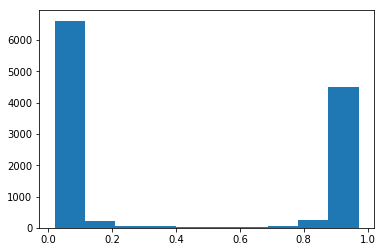

In [108]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(Y)
None

In [103]:
from snorkel import viewer
idx = np.argsort(Y)
idx = idx[-100:]
viewer.SentenceNgramViewer(
    candidates=[X[i] for i in idx], 
    session=session
)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[2, 3, 5, 14, 15, 16, 17, 18, 19], [4], [1]], [[0, 24], [7, 8, 9, 10, 20, 21, 22, 2…